At the moment - this has a quick first pass of comparing chlorophyll to sea ice area.

Might be developed further or shelved.

# Imports

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#some constants
CLIMAT_DATES=[1998,2020]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo.xr

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology
from utils.sea_ice_conc import sea_ice_conc

%run {_work_dir}utils/plot_tools.ipynb



# Chlor Data

In [5]:
# place holder for how to do this in python
from os import listdir
file_names = listdir(f'{_data_dir}OCCCI/')
files = [f'{_data_dir}OCCCI/{iFile}' for iFile in file_names]

In [6]:
big_chlor_da=xr.open_mfdataset(files).chlor_a

In [7]:
big_chlor_da

<xarray.DataArray 'chlor_a' (time: 292, lat: 4320, lon: 8640)>
dask.array<concatenate, shape=(292, 4320, 8640), dtype=float32, chunksize=(1, 4320, 8640), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2021-12-01
Attributes:
    long_name:            Chlorophyll-a concentration in seawater (not log-tr...
    units:                milligram m-3
    ancillary_variables:  chlor_a_log10_rmsd chlor_a_log10_bias
    grid_mapping:         crs
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard:    mg m^-3

In [8]:
chlor_da=big_chlor_da.where(big_chlor_da.lat<-40, drop=True)

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
#chlor_da=chlor_da.odc.assign_crs("epsg:54008")

In [10]:
climat_chlor_ds=climatology(chlor_da, CLIMAT_DATES)

In [11]:
anoms_da=chlor_da.groupby('time.month')-climat_chlor_ds.ave

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


# Sea Ice Conc

Using the NSIDC Sea Ice Concentration gridded data set, historical monthly averages of sea ice concentration

In [12]:
hist_cdr_xr = xr.open_dataset(
    f'{_data_dir}/NSIDC/G02202_V4/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
    #chunks='auto'
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'cdr_seaice_conc_monthly':'cdr_seaice_conc','xgrid':'x','ygrid':'y'}
)

We are going to compare this to the current (2022) conditions:

In [13]:
daily_files = ! ls -d {_data_dir}/NSIDC/G10016_V2/daily/*.nc

In [14]:
daily_da=xr.concat(
    [
        xr.open_dataset(
            iFile,
        ).swap_dims(
            {'tdim':'time', 'x':'xgrid','y':'ygrid'}
        ).rename(
            {'xgrid':'x','ygrid':'y'}
        ) for iFile in daily_files
    ], 
    'time'
)

#we could resample to monlthy, but daily data actually works fine
current_cdr_xr=daily_da#.resample(time='M',label='left', loffset='1D').mean('time')

Put the historical monthly data, and the near real time data in one array:

In [15]:
# If the two datasets have gone out of sync, raise an error.
# This would be amiguous, the historical (released data) and the current (near-real time data) 
# are covering the same times and we don't know which one to use.
if hist_cdr_xr.time_coverage_end>current_cdr_xr.time_coverage_start:
    raise RuntimeError("Times in historical data overlap with near-real time data")

cdr_ds=xr.concat(
    [hist_cdr_xr.cdr_seaice_conc, current_cdr_xr.cdr_seaice_conc], #this is the only data field we use
    'time'
)

#merge the long and lat back in for convenience
cdr_xr=xr.merge(
    [
        cdr_ds,
        hist_cdr_xr.longitude,
        hist_cdr_xr.latitude]
)

cdr_xr

<xarray.Dataset>
Dimensions:          (time: 752, x: 316, y: 332)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-08-22
  * x                (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y                (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
Data variables:
    cdr_seaice_conc  (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude        (y, x) float32 ...
    latitude         (y, x) float32 ...
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

Annoyingly, the area of each grid cell is provided seperately:

In [16]:
datFile=open('/g/data/jk72/MIZ/NSIDC/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

In [17]:
cdr_xr=cdr_xr.odc.assign_crs("epsg:3976")

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/odc/geo/_xr_interop.py:266: UserWarning: grid_mapping=projection is not pointing to valid coordinate
  warnings.warn(


# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. 

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area

In [18]:
ant_conc=sea_ice_conc(cdr_xr.cdr_seaice_conc, areasKmNd ) #local class

# Annual mins / maxes

In [19]:
ant_conc.calc_area()

In [20]:
means_chlor_da=chlor_da.where(
    #(chlor_da.lon>EAST_ANT_LONS[0])
    #*(chlor_da.lon<EAST_ANT_LONS[1])
    #*
    (chlor_da.lat<-55)
).mean(['lat','lon']).load()

In [21]:
conc_annual_max = ant_conc.area_da.groupby('time.year').max()

chlor_annual_min = means_chlor_da.groupby('time.year').min().load()

merged_ds=xr.merge([conc_annual_max,chlor_annual_min])

Annual max concentration vs annual min chlor

Arguably a bit meaningless because the min is always very low / nominal??

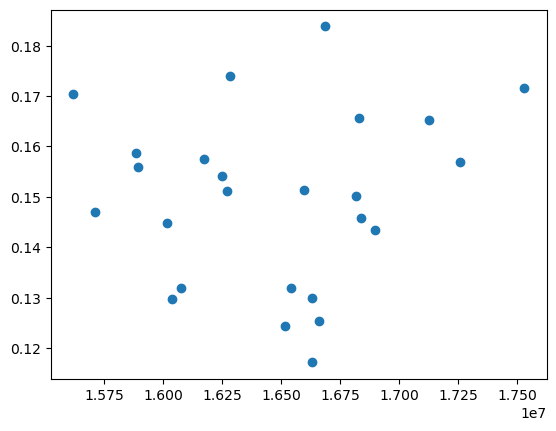

In [22]:
plt.scatter(
    merged_ds.cdr_seaice_conc,
    merged_ds.chlor_a
)

Conc min vs chlor max

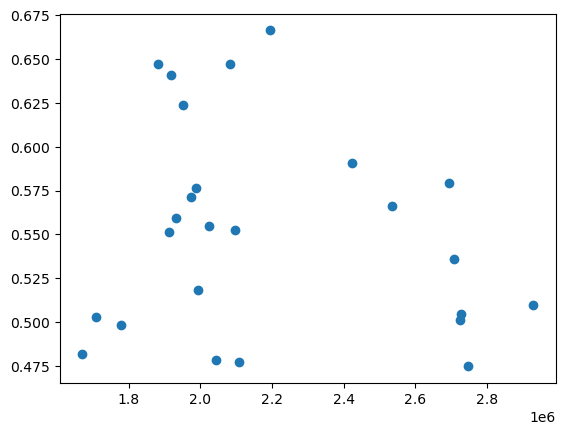

In [23]:
conc_annual_min = ant_conc.area_da.groupby('time.year').min()

chlor_annual_max = means_chlor_da.groupby('time.year').max().load()

merged_ds=xr.merge([conc_annual_min,chlor_annual_max])

plt.scatter(
    merged_ds.cdr_seaice_conc,
    merged_ds.chlor_a
)

Conc max vs chlor max

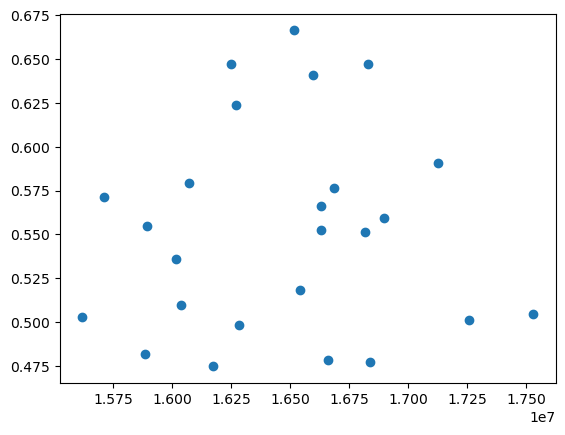

In [24]:
merged_ds=xr.merge([conc_annual_max,chlor_annual_max]).sel(year=slice(1997,2021))

plt.scatter(
    merged_ds.cdr_seaice_conc,
    merged_ds.chlor_a, 
)



In [25]:
p,r,_,_,_ = np.polyfit(
    merged_ds.cdr_seaice_conc,
    merged_ds.chlor_a, 
    1,
    full=True
)

In [26]:
p

array([5.49936456e-09, 4.61847656e-01])

In [27]:
r

array([0.08276971])

# Monthly means

In [28]:
area_month = ant_conc.area_da.groupby('time.month').mean()

chlor_month = means_chlor_da.groupby('time.month').mean().load()

In [29]:
means_chlor_da.load()

<xarray.DataArray 'chlor_a' (time: 292)>
array([0.17393331, 0.1903066 , 0.2638161 , 0.49840516, 0.47823563,
       0.35619596, 0.20099801, 0.15556408, 0.13901263,        nan,
              nan, 0.12528987, 0.14764127, 0.2092599 , 0.27285436,
       0.4672905 , 0.45244372, 0.38430223, 0.20759337, 0.154882  ,
       0.13503133,        nan,        nan, 0.13194133, 0.1486526 ,
       0.19174436, 0.31275675, 0.5181085 , 0.55148107, 0.4438111 ,
       0.2378425 , 0.17866582,        nan,        nan,        nan,
       0.1501847 , 0.15558794, 0.1920069 , 0.25082073, 0.3728282 ,
       0.42093644, 0.40729368, 0.214369  , 0.16931486,        nan,
              nan,        nan, 0.1318625 , 0.1451513 , 0.1915003 ,
       0.33552507, 0.5792953 , 0.55502677, 0.36557147, 0.22284605,
       0.1559157 ,        nan,        nan,        nan, 0.16288385,
       0.15838857, 0.17514552, 0.255236  , 0.43020883, 0.47090858,
       0.3932193 , 0.25161937, 0.16681287, 0.13506077,        nan,
              nan, 0.12974852, 0.15164821, 0.22755179, 0.30315146,
       0.5095646 , 0.54872334, 0.44948006, 0.27808064, 0.17128079,
       0.11716357,        nan,        nan, 0.13435712, 0.14707494,
       0.19673152, 0.3072998 , 0.5659864 , 0.55265963, 0.39515048,
       0.26109257, 0.1717824 , 0.15925565,        nan,        nan,
       0.13000569, 0.14488582, 0.19643071, 0.34553635, 0.51977634,
...
       0.48259175, 0.5045899 , 0.39388227, 0.30575868, 0.20812026,
       0.22041203,        nan,        nan, 0.17151125, 0.17495587,
       0.2060711 , 0.30250257, 0.48676553, 0.47478494, 0.3826476 ,
       0.27887186, 0.18885028, 0.2080139 ,        nan,        nan,
       0.17103891, 0.15746671, 0.21091153, 0.29580826, 0.47184873,
       0.5713509 , 0.52039164, 0.2932762 , 0.19119865, 0.14707042,
              nan,        nan, 0.17250517, 0.16328052, 0.2261009 ,
       0.3828935 , 0.536609  , 0.5029371 , 0.39703324, 0.28144565,
       0.21472688, 0.17096052,        nan,        nan, 0.18000478,
       0.17034937, 0.21660228, 0.38504183, 0.48275775, 0.4818466 ,
       0.41357493, 0.29524365, 0.19286515, 0.22089007,        nan,
              nan, 0.16494057, 0.15873183, 0.21011333, 0.31138897,
       0.4523892 , 0.52457184, 0.43154386, 0.29317024, 0.19486134,
       0.18476714,        nan,        nan, 0.15109757, 0.18382925,
       0.2149261 , 0.44814083, 0.6236552 , 0.57542837, 0.45448044,
       0.30501658, 0.22105029, 0.20396413,        nan,        nan,
       0.18385154, 0.19292675, 0.22793788, 0.33286616, 0.57663983,
       0.6470919 , 0.5897286 , 0.40922382, 0.25135884, 0.1541301 ,
              nan,        nan, 0.29471013, 0.2154213 , 0.24935694,
       0.36341938, 0.64333266], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2021-12-01

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [31]:
cmap = cm.get_cmap('hsv')

In [33]:
merged_ds=xr.merge([ant_conc.area_da,means_chlor_da])

Text(0.5, 1.0, 'Monthly Averages')

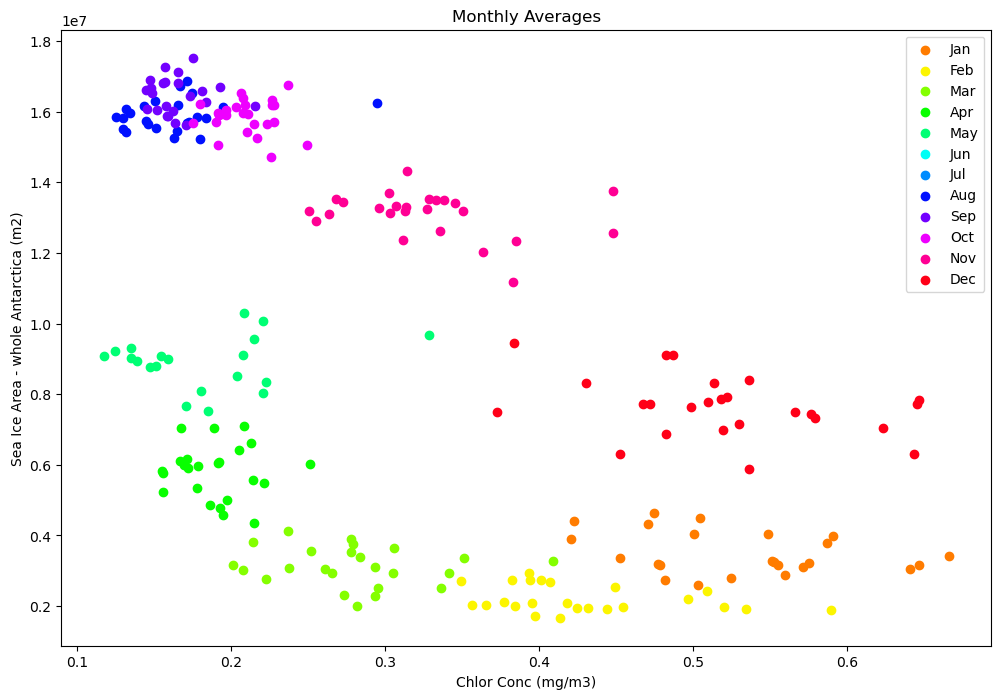

In [34]:
plt.figure(figsize=(12,8))

for iMonth in np.arange(1,12.1,1) :
    
    to_plot=merged_ds.where(merged_ds.time.dt.month==iMonth,drop=True)

    plt.scatter(
        to_plot.chlor_a, 
        to_plot.cdr_seaice_conc,
        color=colors.rgb2hex(cmap(iMonth/12))
    )
    
plt.legend(labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Sea Ice Area - whole Antarctica (m2)')
plt.xlabel('Chlor Conc (mg/m3)')
plt.title('Monthly Averages')

In [35]:
years = np.unique(merged_ds.where(~merged_ds.chlor_a.isnull(), drop=True).time.dt.year)

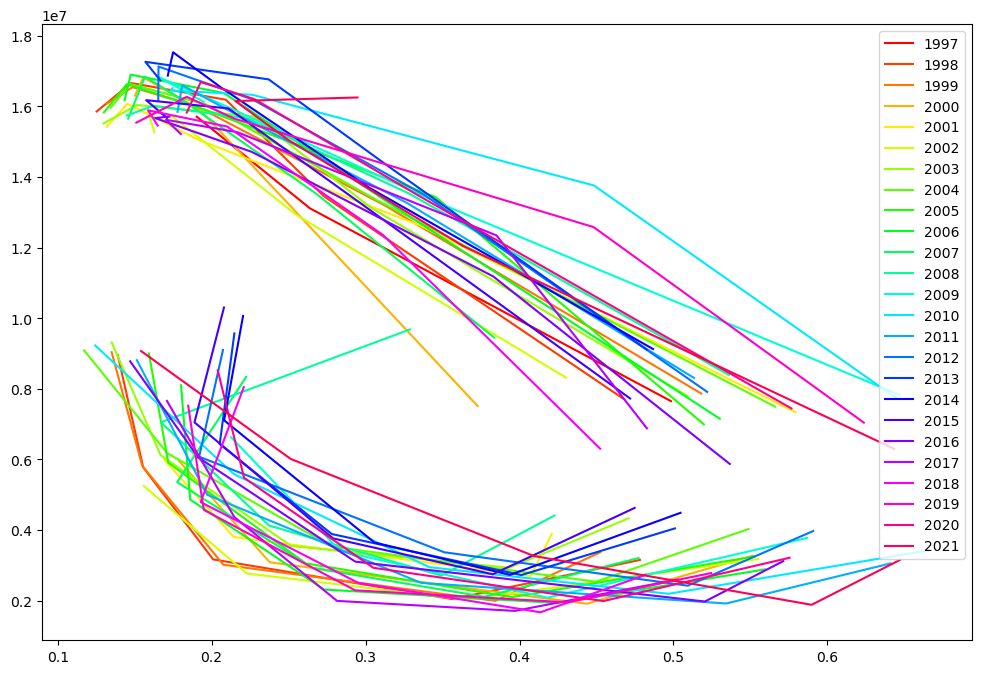

In [36]:
plt.figure(figsize=(12,8))

for iYear in years:
    to_plot=merged_ds.where(merged_ds.time.dt.year==iYear,drop=True)

    plt.plot(
        to_plot.chlor_a,
        to_plot.cdr_seaice_conc,
        label=iYear,
        color=colors.rgb2hex(cmap((iYear-years[0])/len(years)))
    )
    
plt.legend()